# **강화 학습**

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장 ' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)


if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')

# 깔끔한 그래프 출력을 위해
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 부드러운 애니메이션을 위해
mpl.rc('animation', html='jshtml')

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)

2023-06-30 14:38:56.177415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 14:39:03.425120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-30 14:39:04.016172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-30 14:39:04.016499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu

## OpenAI 짐

이 노트북은 강화학습 알고리즘을 개발하고 평가하는 훌륭한 도구인 [OpenAI 짐(gymnasium)](https://gymnasium.farama.org/)을 사용한다. 학습 에이전트가 상호작용하기 위한 환경을 많이 제공한다. 먼저 `gymnasium`을 임포트한다:

In [2]:
import gymnasium as gym

가능한 환경 목록을 확인한다:

In [3]:
gym.envs.registry.values()

dict_values([EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=Fals

Cart-Pole은 매우 간단한 환경으로 왼쪽과 오른쪽으로 움직이는 카트와 그 위에 수직으로 놓여 있는 막대로 구성된다. 에이전트는 카트를 왼쪽이나 오른쪽으로 움직여 막대가 바로 서 있도록 만들어야 한다.

In [4]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

`reset()` 메서드를 호출해 환경을 초기화한다. 이 메서드는 관측을 반환한다:

In [5]:
obs, _ = env.reset(seed=42)

관측은 환경에 따라 다르다. 이 경우 4개의 실수로 구성된 1D 넘파이 배열이다. 카트의 수평 위치, 속도, 막대의 각도(0=수직), 각속도를 나타낸다.

In [6]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

환경은 `render()` 메서드를 호출하여 시각화할 수 있다. 그리고 렌더링 모드(환경에 따른 렌더링 옵션)를 선택할 수 있다.

**경고**: (Cart-Pole을 포함해) 일부 환경은 화면 접근 권한이 필요하다. `render_mode='rgb_array'`로 지정하더라도 별도의 윈도우를 연다. 일반적으로 이 윈도우를 무시할 수 있다.

In [7]:
env.render()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

이 예에서는 `render_mode='rgb_array'`로 지정해 환경 이미지를 넘파이 배열로 받는다:

In [8]:
img = env.render()
img.shape

(400, 600, 3)

In [9]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis('off')
    return img

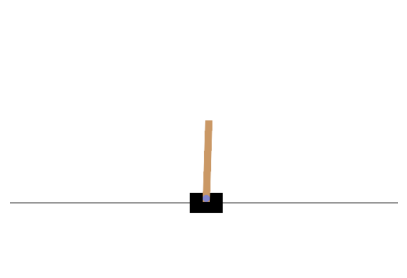

In [10]:
plot_environment(env)
plt.show()

환경과 상호작용하는 방법을 알아 본다. 에이전트는 "행동 공간"(가능한 행동의 집합)에서 하나의 행동을 선택해야 한다. 이 환경의 행동 공간을 다음처럼 확인한다:

In [11]:
env.action_space

Discrete(2)

단 두 개의 행동이 가능하다: 왼쪽 또는 오른쪽으로 가속한다.

막대가 오른쪽으로 기울어져 있기 때문에(`obs[2] > 0`), 카트를 오른쪽으로 가속한다:

In [12]:
action = 1  # 오른쪽으로 가속
obs, reward, terminated, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

이제 카트가 오른쪽으로 움직였다(`obs[1] > 0`). 막대가 여전히 오른쪽으로 기울었다(`obs[2] > 0`). 하지만 각속도가 음수이므로(`obs[3] < 0`) 다음 스텝에서는 왼쪽으로 기울 것이다.

그림 저장 cart_pole_plot


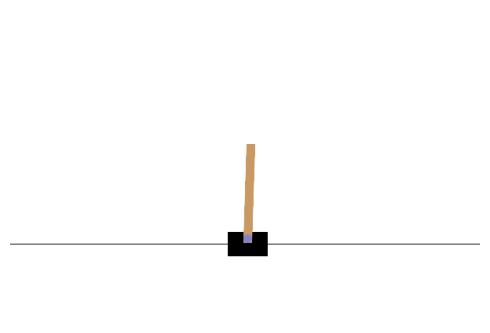

In [13]:
plot_environment(env)
save_fig('cart_pole_plot')

요청한 대로 실행된다!

환경은 이전 스텝에서 얼마나 많은 보상을 받는지 에이전트에게 알린다:

In [14]:
reward

1.0

게임이 끝나면 환경은 `terminated = True`나 `truncated = True`를 반환한다:

In [15]:
terminated, truncated

(False, False)

마지막으로 `info`는 훈련이나 디버깅에 유용한 추가적인 정보를 담은 환경에 특화된 딕셔너리이다. 예를 들어 일부 게임에서는 얼마나 많은 에이전트의 생명이 몇 개가 남아 있는지 나타낸다.

In [16]:
info

{}

환경이 재설정된 순간부터 종료될 때까지 스텝 시퀀스를 "에피소드"라고 한다. 에피소드 끝에서(즉, `step()`이 `terminated = True`나 `truncated = True`를 반환할 때), 계속하기 전에 환경을 재설정해야 한다.

In [17]:
if terminated | truncated:
    env.reset()

그럼 어떻게 막대를 똑바로 유지할 수 있을까? 이를 위해 정책을 정의해야 한다. 에이전트가 매 스텝마다 행동을 선택하기 위해 사용할 전략이다. 어떤 행동을 선택할지 결정하기 위해 지난 행동과 관측을 모두 사용할 수 있다.

**간단한 하드 코딩 정책**

간단한 정책을 하드 코딩한다. 막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 움직이고 오른쪽으로 기울어지면 반대로 움직인다. 어떻게 작동하는지 확인한다:

In [18]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1


totals = []
for episode in range(500):
    episode_rewards = 0
    obs, _ = env.reset()
    while True:
        action = basic_policy(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        episode_rewards += reward
        if terminated | truncated:
            break
    totals.append(episode_rewards)

In [19]:
import numpy as np

np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.18, 9.015963620157304, 24.0, 72.0)

예상대로 이 전략은 너무 단순하다. 최대로 막대를 유지한 스텝 횟수가 72이다. 이 환경은 에이전트가 막대를 200 스텝 이상 유지해야 해결된 것으로 간주한다.

하나의 에피소드를 시각화한다:

In [20]:
frames = []
obs, _ = env.reset()
while True:
    img = env.render()
    frames.append(img)
    action = basic_policy(obs)
    obs, _, terminated, truncated, _ = env.step(action)
    if terminated | truncated:
        break

애니메이션을 출력합니다:

In [21]:
import matplotlib.animation as animation


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch


def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, len(frames), fargs=(frames, patch), repeat=repeat, interval=interval
    )
    plt.close()
    return anim

In [22]:
plot_animation(frames)

확실히 이 방법은 불안정해서 약간 흔들리면 막대가 너무 기울어져 게임이 끝난다. 이 보다는 더 똑똑한 전략이 필요하다!

## 신경망 정책

관측을 입력으로 받고 각 관측에 대해 선택할 행동의 확률을 출력하는 신경망을 만든다. 행동을 선택하기 위해 신경망은 각 행동의 확률을 추정한다. 이 추정된 확률에 따라 랜덤하게 행동을 선택한다. Cart-Pole 환경의 경우 두 개의 가능한 행동이 있다(왼쪽과 오른쪽). 따라서 하나의 출력 뉴런만 있으면 된다. 이 뉴런은 행동 0(왼쪽)의 확률 `p`를 출력한다. 물론 행동 1(오른쪽)의 확률은 `1 - p`이다.

In [23]:
from tensorflow import keras

keras.backend.clear_session()
n_inputs = 4  # == env.observation_space.shape[0]
model = keras.Sequential([keras.layers.Dense(5, 'elu', input_shape=[n_inputs]), keras.layers.Dense(1, 'sigmoid')])

2023-06-30 14:39:09.210754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-30 14:39:09.210967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-30 14:39:09.211143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-30 14:39:10.692733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-30 14:39:10.692966: I tensorflow/compile

이 환경에서는 지난 행동과 관측을 무시한다. 각 관측이 완전한 환경의 상태를 담고 있기 때문이다. 은닉 상태가 있다면 환경의 은닉 상태를 추정하기 위해 지난 행동과 관측을 고려한다. 예를 들어, 이 환경이 카트의 위치만 제공하고 속도를 알려 주지 않는다면, 현재 속도를 추정하기 위해 현재 관측 뿐만 아니라 지난 관측도 고려한다. 또 다른 예는 관측에 잡음이 있는 경우이다. 가장 가능성 있는 현재 상태를 추정하기 위해 지난 몇 개의 관측을 사용한다. 이 문제는 매우 간단하다. 현재 관측에 잡음이 없고 환경의 모든 상태가 담긴다.

정책 네트워크가 출력한 확률 중에서 가장 높은 확률을 가진 행동을 선택하지 않고 랜덤한 행동을 선택하는 이유가 궁금할지 모른다. 이 방법은 에이전트가 새로운 행동을 탐험하는 것과 잘 동작하는 행동을 활용하는 것 사이에 밸런스를 찾도록 한다. 비유를 들겠다. 한 음식점에 처음 방문했다고 가정한다. 모든 음식에 대한 선호도가 동일하다면 랜덤하게 하나를 선택한다. 이 음식이 좋다고 느낀다면 다음 번에 이 음식을 주문할 확률을 높일 수 있다. 하지만 이 확률을 100%로 높여서는 안 된다. 그렇지 않으면 다른 음식을 시도해 볼 수 없다. 어쩌면 다른 음식이 이번에 먹은 것보다 훨씬 더 좋을 수도 있다.

모델을 실행하여 한 에피소드를 플레이하고 애니메이션을 위한 프레임을 반환하는 함수를 작성한다:

In [24]:
from numpy.random import default_rng


def render_policy_net(model):
    frames = []
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    obs, _ = env.reset()
    while True:
        frames.append(env.render())
        left_proba = model.predict(obs.reshape(1, -1), use_multiprocessing=True)
        action = int(rng.random() > left_proba)
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated | truncated:
            break
    env.close()
    return frames


rng = default_rng()

랜덤하게 초기화된 정책 네트워크가 얼마나 잘 수행하는지 확인한다:

In [25]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 15ms/step


2023-06-30 14:39:16.672485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 15ms/step


아주 나쁘다. 이 신경망은 더 배워야 한다. 먼저 앞에서 사용한 기본적인 정책을 학습할 수 있는지 확인한다. 막대가 왼쪽으로 기울면 왼쪽으로 움직이고, 오른쪽으로 기울면 오른쪽으로 움직이도록 한다.

같은 신경망으로 동시에 50개의 다른 환경을 플레이한다(이렇게 하면 각 스텝마다 다양한 훈련 배치를 얻는다). 그리고 5000번 반복 동안에 훈련한다. 게임이 종료되면 환경을 재설정한다. 사용자 정의 훈련 루프를 사용하여 모델을 훈련하기 때문에 훈련 스텝마다 환경에 앞서 예측을 쉽게 만들 수 있다.

In [26]:
n_environments = 50
n_iterations = 5000
envs = [gym.make('CartPole-v1') for _ in range(n_environments)]
observations = [env.reset()[0] for env in envs]
optimizer = keras.optimizers.experimental.RMSprop()
loss_fn = keras.losses.BinaryCrossentropy()
for iteration in range(n_iterations):
    # angle < 0이면 proba(left) = 1., 그렇지 않으면 proba(left) = 0.이 된다.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.math.reduce_mean(loss_fn(target_probas, left_probas))
    print(f'Iteration: {iteration}, Loss: {loss.numpy():.3f}', end='\r')
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (rng.random((n_environments, 1)) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, _, terminated, truncated, _ = env.step(actions[env_index][0])
        observations[env_index] = obs if not terminated | truncated else env.reset()[0]
for env in envs:
    env.close()

2023-06-30 14:39:18.238176: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x35815510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-30 14:39:18.238229: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-06-30 14:39:18.478954: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-30 14:39:24.736022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-06-30 14:39:25.425171: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-30 14:39:25.782650: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [27]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 14ms/step


정책을 잘 학습했다. 이제 스스로 더 나은 정책을 학습할 수 있는지 확인한다.

## 정책 그레이디언트

이 신경망을 훈련하려면 타깃 확률 `y`를 정의해야 한다. 행동이 좋으면 해당 확률을 증가시키고 반대로 나쁘면 감소시킨다. 하지만 행동이 좋은지 나쁜지 어떻게 알까? 대부분 행동의 효과가 지연되어 나타나기 때문에 한 에피소드에서 점수를 얻거나 잃을 때 어떤 행동이 이 결과에 기여했는지 명확하지 않다. 마지막 행동일까? 아니면 마지막에서 10번째 행동일까? 아니면 50 스텝 이전의 행동일까? 이를 _신용 할당 문제_ 라고 부른다.

_정책 그레이디언트_ 알고리즘은 이 문제를 해결하기 위해 먼저 여러 개의 에피소드를 플레이하고 그다음 좋은 에피소드에 있는 행동의 가능성을 조금 더 높이고, 나쁜 에피소드에 있는 행동의 가능성을 조금 낮춘다. 먼저 플레이해보고 다시 돌아가서 수행한 작업을 생각해 본다.

이 모델을 사용해 하나의 스텝을 플레이하는 함수를 만든다. 지금은 선택한 행동이 모두 좋다고 가정하고 손실과 그레이디언트를 계산한다(그레이디언트를 저장하고 나중에 행동이 좋은지 나쁜지에 따라 수정한다):

In [28]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = tf.random.uniform([1, 1]) > left_proba
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.math.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, terminated, truncated, _ = env.step(int(action[0, 0].numpy()))
    return obs, reward, terminated, truncated, grads

`left_proba`가 높으면 `action`이 `False`가 될 가능성이 높다(0~1 사이에서 균등 분포로 난수를 샘플링하면 `left_proba`보다 높지 않을 가능성이 높기 때문에). 그리고 `False`를 숫자로 바꾸면 0이므로 `y_target`은 1 - 0 = 1이다. 다른 말로 하면 타깃을 1로 지정하는 것은 왼쪽일 확률을 100%로 가정한다는 의미이다(따라서 올바른 행동을 선택했다).

이제 `play_one_step()` 함수를 사용해 여러 개의 에피소드를 플레이하고 에피소드와 스텝마다 모든 보상과 그레이디언트를 반환하는 또 다른 함수를 만든다:

In [29]:
def play_multiple_episodes(env, n_episodes, model, loss_fn):
    all_rewards = []
    all_grads = []
    for _ in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, _ = env.reset()
        while True:
            obs, reward, terminated, truncated, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if terminated | truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

정책 그레이디언트 알고리즘은 모델을 사용해 여러 번 에피소드를 플레이한다(예를 들어 10번). 그다음 모든 보상을 할인하고 정규화한다. 이를 위한 함수를 만들어 본다. 첫 번째 함수는 할인된 보상을 계산한다. 두 번째 함수는 여러 에피소드에 걸쳐 할인된 보상을 정규화한다.

In [30]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted


def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

3개의 행동을 수행하고 각 행동의 보상이 10, 0, -50이라고 가정해 본다. 80%의 할인 계수를 사용하면 세 번째 행동은 -50(마지막 보상의 100%)를 받지만 두 번째 행동은 -40(마지막 보상의 80%)만 받는다. 그리고 첫 번째 행동은 -40의 80%(-32)에 첫 번째 보상(+10)의 100%를 받는다. 따라서 할인된 보상의 합은 -22가 된다:

In [31]:
discount_rewards([10, 0, -50], .8)

array([-22, -40, -50])

전체 에피소드에 대해 모든 할인된 보상을 정규화하기 위해 전체 할인된 보상의 평균과 표준 편차를 계산한다. 그리고 할인된 보상에서 평균을 빼고 표준 편차를 나눈다:

In [32]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], .8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [33]:
n_iterations = 150
n_episodes_per_update = 10
discount_rate = .95

In [34]:
optimizer = keras.optimizers.Adam(.01)
loss_fn = keras.losses.BinaryCrossentropy()

In [35]:
keras.backend.clear_session()
model = keras.Sequential([keras.layers.Dense(5, 'elu', input_shape=[4]), keras.layers.Dense(1, 'sigmoid')])

In [36]:
env = gym.make('CartPole-v1')
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))
    print(f'Iteration: {iteration}, mean rewards: {total_rewards / n_episodes_per_update:.1f}', end='\r')
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.math.reduce_mean(
            [
                final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)
            ],
            0
        )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
env.close()

KeyboardInterrupt: 

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

## 마르코프 결정 과정

**마르코프 연쇄**

In [ ]:
def print_sequence():
    current_state = 0
    print('States:', end='')
    for _ in range(n_max_steps):
        print(f' {current_state}', end='')
        if current_state == 3:
            break
        current_state = rng.choice(4, p=transition_probabilities[current_state])
    else:
        print('...', end='')
    print()


transition_probabilities = [  # shape=[s, s']
    [.7, .2, 0., .1],  # s0에서 s0, s1, s2, s3까지
    [0., 0., .9, .1],  # s1에서 ...까지
    [0., 1., 0., 0.],  # s2에서 ...까지
    [0., 0., 0., 1.]  # s3에서 ...까지
]
n_max_steps = 50
for _ in range(10):
    print_sequence()

**마르코프 결정 과정**

전이 확률, 보상, 가능한 행동을 정의해 보자. 예를 들어, 상태 s0에서 행동 a0가 선택되면 0.7의 확률로 상태 s0로 가고 +10 보상을 받는다. 그리고 0.3의 확률로 상태 s1으로 가고 보상이 없다. 상태 s2로는 이동하지 않는다(따라서 전이 확률은 `[0.7, 0.3, 0.0]`이고 보상은 `[+10, 0, 0]`이다):

In [ ]:
transition_probabilities = [  # shape=[s, a, s']
    [[.7, .3, 0.], [1., 0., 0.], [.8, .2, 0.]], [[0., 1., 0.], None, [0., 0., 1.]], [None, [.8, .1, .1], None]
]
rewards = [  # shape=[s, a, s']
    [[10, 0, 0], [0, 0, 0], [0, 0, 0]], [[0, 0, 0], [0, 0, 0], [0, 0, -50]], [[0, 0, 0], [40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

**Q-가치 반복**

In [ ]:
Q_values = np.full((3, 3), -np.inf)  # 불가능한 행동은 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.  # 모든 가능한 행동에 대해

In [ ]:
gamma = .9  # 할인 계수
history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum(
                [
                    transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.amax(Q_prev[sp]))
                    for sp in range(3)
                ]
            )
history1 = np.array(history1)

In [ ]:
Q_values

In [ ]:
np.argmax(Q_values, 1)

할인 계수 0.9를 사용했을 때 이 MDP의 최적 정책은 상태 s0에서 행동 a0를 선택하고, 상태 s1에서 행동 a0를 선택하고, 마지막으로 상태 s2에서 행동 a1(선택 가능한 유일한 행동)을 선택하는 것이다.

할인 계수 0.95로 시도해 보자:

In [ ]:
Q_values = np.full((3, 3), -np.inf)  # 불가능한 행동에 대해서는 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.  # 모든 가능한 행동에 대해서

In [ ]:
gamma = .95  # 할인 계수
for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum(
                [
                    transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.amax(Q_prev[sp]))
                    for sp in range(3)
                ]
            )

In [ ]:
Q_values

In [ ]:
np.argmax(Q_values, 1)

이제 정책이 바뀌었다! 상태 s1에서 불 속으로 들어가는 것을 선택한다(행동 a2). 할인 계수가 크기 때문에 에이전트가 미래에 더 많은 가치를 두기 때문에 미래 보상을 얻기 위해 당장의 불이익을 감내한다.

## Q-러닝

Q-러닝은 에이전트의 (예를 들면, 랜덤한) 플레이를 보고 점진적으로 Q-가치 추정을 향상한다. 정확한 (또는 충분히 가까운) Q-가치 추정을 얻으면 최적의 정책은 가장 높은 Q-가치를 가진 행동을 선택하는 것이다(즉, 그리디 정책).

환경을 돌아다니는 에이전트를 시뮬레이션해야 한다. 따라서 행동을 선택하고 새로운 상태와 보상을 받는 함수를 정의해 본다:

In [ ]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = rng.choice(3, p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

또한 탐험 정책도 필요하다. 가능한 모든 상태를 여러번 방문한다면 어떤 정책도 가능하다. 상태 공간이 매우 작기 때문에 랜덤한 정책을 사용하겠다:

In [ ]:
def exploration_policy(state):
    return rng.choice(possible_actions[state])

In [ ]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0
alpha0 = .05  # 초기 학습률
decay = .005  # 학습률 감쇄
gamma = .9  # 할인 계수
state = 0  # 초기 상태
history2 = []
for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.amax(Q_values[next_state])  # 다음 스텝의 그리디 정책
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state
history2 = np.array(history2)

In [ ]:
Q_values

In [ ]:
np.argmax(Q_values, 1)  # 각 상태에 대한 최적의 행동

In [ ]:
true_Q_value = history1[-1, 0, 0]
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
axes[0].set_ylabel('Q-Value$(s_0, a_0)$', fontsize=14)
axes[0].set_title('Q-Value Iteration', fontsize=14)
axes[1].set_title('Q-Learning', fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], 'k--')
    ax.plot(np.arange(width), history[:, 0, 0], 'b-', linewidth=2)
    ax.set_xlabel('Iterations', fontsize=14)
    ax.axis([0, width, 0, 24])
save_fig('q_value_plot')

## 심층 Q-러닝 구현하기

DQN을 만들어 본다. 상태가 주어지면 가능한 모든 행동에 대해서 행동을 플레이한 후 (하지만 결과를 보기 전에) 기대할 수 있는 할인된 미래 보상의 합을 추정한다:

In [ ]:
keras.backend.clear_session()
env = gym.make('CartPole-v1', render_mode='rgb_array')
input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n
model = keras.Sequential(
    [
        keras.layers.Dense(32, 'elu', input_shape=input_shape), keras.layers.Dense(32, 'elu'),
        keras.layers.Dense(n_outputs)
    ]
)

이 DQN을 사용해 행동을 선택하려면 가장 큰 예측 Q-가치를 가진 행동을 선택하면 된다. 하지만 에이전트가 환경을 탐험하려면 `epsilon` 확률로 랜덤한 행동을 선택한다.

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if rng.random() < epsilon:
        return rng.integers(n_outputs)
    Q_values = model.predict(state[np.newaxis], verbose=0, use_multiprocessing=True)
    return np.argmax(Q_values[0])

재생 메모리도 필요하다. 여기에는 에이전트의 경험이 담겨 있다. 형식은 `(obs, action, reward, next_obs, terminated, truncated)`와 같다. `deque` 클래스를 사용할 수 있다(더 강력한 경험 재생의 구현을 위해 딥마인드의 [Reverb 라이브러리](https://github.com/deepmind/reverb)를 참고한다):

In [ ]:
from collections import deque

replay_memory = deque(maxlen=2000)

그리고 재생 메모리에서 경험을 샘플링하는 함수를 만든다. 이 함수는 5개의 넘파이 배열 `[states, actions, rewards, next_obs, terminateds, truncateds]`을 반환한다.

In [ ]:
def sample_experiences(batch_size):
    indices = rng.integers(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, terminateds, truncateds = [
        np.array([experience[field_index] for experience in batch]) for field_index in range(6)
    ]
    return states, actions, rewards, next_states, terminateds, truncateds

이제 DQN을 사용해 한 스텝을 플레이하는 함수를 만들고 경험을 재생 메모리에 기록할 수 있다:

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, terminated, truncated, _ = env.step(action)
    replay_memory.append((state, action, reward, next_state, terminated, truncated))
    return next_state, terminated, truncated

마지막으로 재생 메모리에서 약간의 경험을 샘플링하고 훈련 스텝을 수행하는 함수를 만들어 본다:

In [ ]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, terminateds, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0, use_multiprocessing=True)
    max_next_Q_values = np.amax(next_Q_values, 1)
    target_Q_values = rewards + (1 - (terminateds | truncateds)) * discount_rate * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.math.reduce_sum(all_Q_values * mask, 1, True)
        loss = tf.math.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


batch_size = 32
discount_rate = .95
optimizer = keras.optimizers.Adam(1e-2)
loss_fn = keras.losses.MeanSquaredError()

이제 모델을 훈련해 본다!

In [ ]:
rewards = []
best_score = 0

In [ ]:
for episode in range(600):
    obs, _ = env.reset()
    step = 0
    while True:
        epsilon = max(1 - episode / 500, .01)
        obs, terminated, truncated = play_one_step(env, obs, epsilon)
        if terminated | truncated:
            break
        step += 1
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print(f'Episode: {episode}, Steps: {step + 1:3}, eps: {epsilon:.3f}', end='\r')
    if episode > 50:
        training_step(batch_size)
model.set_weights(best_weights)

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Sum of rewards', fontsize=14)
save_fig('dqn_rewards_plot')
plt.show()

In [ ]:
state, _ = env.reset()
frames = []
while True:
    img = env.render()
    frames.append(img)
    action = epsilon_greedy_policy(state)
    state, _, terminated, truncated, _ = env.step(action)
    if terminated | truncated:
        break
plot_animation(frames)

나쁘지 않다! 😀

## 심층 Q-러닝의 변종

### 더블 DQN

In [ ]:
keras.backend.clear_session()
model = keras.Sequential(
    [keras.layers.Dense(32, 'elu', input_shape=[4]), keras.layers.Dense(32, 'elu'), keras.layers.Dense(n_outputs)]
)
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [ ]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, terminateds, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0, use_multiprocessing=True)
    best_next_actions = np.argmax(next_Q_values, 1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states, verbose=0, use_multiprocessing=True) * next_mask).sum(1)
    target_Q_values = rewards + (1 - (terminateds | truncateds)) * discount_rate * next_best_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.math.reduce_sum(all_Q_values * mask, 1, True)
        loss = tf.math.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


batch_size = 32
discount_rate = .95
optimizer = keras.optimizers.Adam(6e-3)
loss_fn = keras.losses.Huber()

In [ ]:
replay_memory = deque(maxlen=2000)

In [ ]:
rewards = []
best_score = 0
for episode in range(600):
    obs, _ = env.reset()
    step = 0
    while True:
        epsilon = max(1 - episode / 500, .01)
        obs, terminated, truncated = play_one_step(env, obs, epsilon)
        if terminated | truncated:
            break
        step += 1
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print(f'Episode: {episode}, Steps: {step + 1:3}, eps: {epsilon:.3f}', end='\r')
    if episode >= 50:
        training_step(batch_size)
        if not episode % 50:
            target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    # if episode >= 50:
    #     target_weights = target.get_weights()
    #     online_weights = model.get_weights()
    #     for index, online_weight in enumerate(online_weights):
    #         target_weights[index] = .99 * target_weights[index] + .01 * online_weight
    #     target.set_weights(target_weights)
model.set_weights(best_weights)

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Sum of rewards', fontsize=14)
save_fig('double_dqn_rewards_plot')
plt.show()

In [ ]:
state, _ = env.reset()
frames = []
while True:
    img = env.render()
    frames.append(img)
    action = epsilon_greedy_policy(state)
    state, _, terminated, truncated, _ = env.step(action)
    if terminated | truncated:
        break
plot_animation(frames)

In [ ]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, terminateds, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0, use_multiprocessing=True)
    best_next_actions = np.argmax(next_Q_values, 1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states, verbose=0, use_multiprocessing=True) * next_mask).sum(1)
    target_Q_values = rewards + (1 - (terminateds | truncateds)) * discount_rate * next_best_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.math.reduce_sum(all_Q_values * mask, 1, True)
        loss = tf.math.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))


batch_size = 32
discount_rate = .95
optimizer = keras.optimizers.Adam(7.5e-3)
loss_fn = keras.losses.Huber()

In [ ]:
replay_memory = deque(maxlen=2000)

In [ ]:
rewards = []
best_score = 0
for episode in range(600):
    obs, _ = env.reset()
    step = 0
    while True:
        epsilon = max(1 - episode / 500, .01)
        obs, terminated, truncated = play_one_step(env, obs, epsilon)
        if terminated | truncated:
            break
        step += 1
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print(f'Episode: {episode}, Steps: {step + 1:3}, eps: {epsilon:.3f}', end='\r')
    if episode >= 50:
        training_step(batch_size)
        if not episode % 50:
            target.set_weights(model.get_weights())
model.set_weights(best_weights)

In [ ]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Sum of rewards')
plt.show()

In [ ]:
state, _ = env.reset()
frames = []
while True:
    action = epsilon_greedy_policy(state)
    state, _, terminated, truncated, _ = env.step(action)
    if terminated | truncated:
        break
    img = env.render()
    frames.append(img)
plot_animation(frames)

매우 안정적인 에이전트 같다!

In [ ]:
env.close()

## TF-Agents 라이브러리

TF-Agents를 사용해 브레이크아웃 플레이를 학습하는 에이전트를 만들어 본다. 심층 Q-러닝 알고리즘을 사용하겠다. 따라서 이전 구현과 구성 요소를 쉽게 비교할 수 있다. 하지만 TF-Agents에는 다른 (그리고 복잡한) 알고리즘이 많이 구현되어 있다!

### TF-Agents 환경

In [ ]:
import suite_gym

env = suite_gym.load('ALE/Breakout-v5', gym_kwargs={'render_mode': 'rgb_array'})
env

In [ ]:
env.gym

In [ ]:
env.reset()

In [ ]:
env.step(1)  # Fire

In [ ]:
img = env.render()
plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis('off')
save_fig('breakout_plot')
plt.show()

In [ ]:
env.current_time_step()

### 환경 스펙

In [ ]:
env.observation_spec()

In [ ]:
env.action_spec()

In [ ]:
env.time_step_spec()

### 환경 래퍼와 아타리 전처리

TF-Agents 래퍼로 Gymnasium 환경을 감쌀 수 있다:

In [ ]:
from tf_agents.environments import ActionRepeat

repeating_env = ActionRepeat(env, 4)
repeating_env

In [ ]:
repeating_env.unwrapped

가능한 래퍼 목록은 다음과 같다:

In [ ]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, '__base__') and issubclass(obj, tf_agents.environments.PyEnvironmentBaseWrapper):
        n = '\n'
        print(f'{name:27s} {obj.__doc__.split(n)[0]}')

In [ ]:
from functools import partial

from gymnasium.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    'ALE/Breakout-v5',
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)]
)

In [ ]:
limited_repeating_env

In [ ]:
limited_repeating_env.unwrapped

아타리 브레이크아웃 환경을 만들고 기본 아타리 전처리 단계를 적용한다:

**경고**: 브레이크아웃은 게임 시작과 죽을 때마다 FIRE 버튼을 눌러야 한다. 처음에는 FIRE 버튼을 누르는 것이 빨리 지는 것처럼 보이기 때문에 에이전트가 이를 배우는데 매우 오랜 시간이 걸릴 수 있다. 훈련 속도를 높이려면 `AtariPreprocessing` 래퍼 클래스를 상속하여 `AtariPreprocessingWithAutoFire`를 만들고 사용한다. 이 클래스는 게임 시작과 말이 죽을 때마다 자동으로 FIRE(즉 플레이 행동 1)를 누른다.

In [ ]:
from gymnasium.wrappers import AtariPreprocessing

from frame_stack import FrameStack


class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        super().step(1)  # 시작하려면 FIRE
        return obs, info

    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, terminated, truncated, info = super().step(action)
        if self.ale.lives() < lives_before_action and not terminated | truncated:
            super().step(1)  # 생명을 잃은 후 시작하기 위해 FIRE
        return obs, rewards, terminated, truncated, info


max_episode_steps = 27000  # <=> 108k ALE 프레임(1단계 = 4 프레임이므로)
environment_name = 'ALE/Breakout-v5'
env = suite_gym.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithAutoFire, partial(FrameStack, num_stack=4)],
    gym_kwargs={'render_mode': 'rgb_array', 'frameskip': 1}
)

In [ ]:
env

몇 개의 스텝을 플레이하고 어떻게 동작하는지 확인한다:

In [ ]:
env.reset()
for _ in range(4):
    time_step = env.step(3)  # 왼쪽

In [ ]:
def plot_observation(obs):
    # 컬러 채널이 3개이기 때문에 4 프레임을 출력할 수 없다.
    # 따라서 현재 프레임과 다른 프레임의 평균 값을 뺀 차이를 계산한다.
    # 그다음 이 차이를 현재 프레임의 빨강과 파랑 채널에 더해서 보라 색을 구한다.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis('off')

In [ ]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig('preprocessed_breakout_plot')
plt.show()

파이썬 환경을 TF 환경으로 변환한다:

In [ ]:
from tf_agents.environments import TFPyEnvironment

tf_env = TFPyEnvironment(env)

### 심층 Q-네트워크 만들기

관측을 정규화하는 작은 클래스를 만든다. 이미지를 0 ~ 255 사이의 바이트로 저장하는 것이 램을 적게 사용하지만 신경망에는 0.0 ~ 1.0 사이의 실수를 전달해야 한다:

Q-네트워크를 만든다:

In [ ]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params = [512]
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

### DQN 에이전트 만들기

DQN 에이전트를 만든다:

In [ ]:
from tf_agents.agents import DqnAgent

train_step = tf.Variable(0)
update_period = 4  # 4 스텝마다 모델을 훈련한다.
optimizer = keras.optimizers.experimental.RMSprop(2.5e-4, .95, epsilon=.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    1., 250000 // update_period, .01  # 초기 ε, <=> 1,000,000 ALE 프레임, 마지막 ε
)
agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_net,
    optimizer,
    epsilon_greedy=lambda: epsilon_fn(train_step),
    target_update_period=2000,  # <=> 32,000 ALE 프레임
    td_errors_loss_fn=keras.losses.Huber(reduction='none'),
    gamma=.99,  # 할인 계수
    train_step_counter=train_step
)
agent.initialize()

### 재생 버퍼와 옵저버 만들기

재생 버퍼를 만든다(램을 많이 사용하기 때문에 메모리 부족 에러가 나오면 버퍼 크기를 줄인다):

**경고**: 1,000,000이 아닌 100,000 크기의 재생 버퍼를 사용한다. 대부분의 경우 메모리 부족 에러가 나기 때문이다.

In [ ]:
from tf_agents.replay_buffers import TFUniformReplayBuffer

# 100000
replay_buffer = TFUniformReplayBuffer(agent.collect_data_spec, tf_env.batch_size, 10000)  # OOM 에러가 나면 줄인다
replay_buffer_observer = replay_buffer.add_batch

호출 횟수를 카운트하고 출력하는 간단한 사용자 정의 옵저버를 만든다(하나의 스텝으로 카운트하지 않는 두 에피소드 사이의 경계는 제외한다):

In [ ]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total

    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print(f'\r{self.counter}/{self.total}', end='')

### 훈련 측정 지표 만들기

훈련 측정 지표를 추가해 본다:

In [ ]:
import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric()
]

In [ ]:
train_metrics[0].result()

In [ ]:
import logging

from tf_metrics import log_metrics

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

### 수집 드라이버 만들기

수집 드라이버를 만든다:

In [ ]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env, agent.collect_policy, [replay_buffer_observer] + train_metrics, num_steps=update_period
)  # 각 훈련 반복마다 스텝을 4개 수집한다.

훈련 전에 초기 경험을 수집한다:

In [ ]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env, initial_collect_policy, [replay_buffer.add_batch, ShowProgress(20000)], num_steps=20000
)  # <=> 80,000 ALE 프레임
final_time_step, final_policy_state = init_driver.run()

### 데이터셋 만들기

3개의 스텝을 가진 2개의 서브 에피소드를 샘플링해서 출력해 본다:

In [ ]:
trajectories, _ = next(iter(replay_buffer.as_dataset(2, 3)))

In [ ]:
trajectories._fields

In [ ]:
trajectories.observation.shape

In [ ]:
from tf_agents.trajectories import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

In [ ]:
trajectories.step_type.numpy()

In [ ]:
trajectories.observation.numpy()

In [ ]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(0, 0, 1, 1, .02, 0)
save_fig('sub_episodes_plot')
plt.show()

이제 데이터셋을 만들어 본다:

In [ ]:
dataset = replay_buffer.as_dataset(64, 2, 3).prefetch(tf.data.AUTOTUNE)

### 훈련 반복 만들기

성능을 높이기 위해 메인 함수를 TF 함수로 변환한다:

In [ ]:
from tensorflow import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

이제 메인 루프를 실행할 준비가 되었다!

In [ ]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, _ = next(iterator)
        train_loss = agent.train(trajectories)
        print(f'\r{iteration} loss:{train_loss.loss.numpy():.5f}', end='')
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

다음 셀에서 에이전트를 50,000 스텝 동안 훈련한다. 그다음 다음 셀을 실행하여 에이전트의 동작을 살펴본다. 이 두 셀을 원하는 만큼 많이 실행할 수 있다. 에이전트는 점점 향상될 것이다! 에이전트가 어느정도 좋은 동작을 수행하려면 200,000 반복 정도 걸릴 것이다.

In [ ]:
train_agent(50000)

In [ ]:
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render())


frames = []
watch_driver = DynamicStepDriver(tf_env, agent.policy, [save_frames, ShowProgress(1000)], num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()
plot_animation(frames)

In [ ]:
import PIL

image_path = os.path.join('images', 'breakout.gif')
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, 'GIF', append_images=frame_images[1:], save_all=True, duration=30, loop=0)

<img src='images/breakout.gif' />

## Deque vs 로테이팅 리스트

`deque` 클래스는 추가(append)가 빠르지만 랜덤 접근은 느리다(재생 메모리가 클 경우):

In [ ]:
mem = deque(maxlen=1000000)
for i in range(1000000):
    mem.append(i)
[mem[i] for i in rng.integers(1000000, size=5)]

In [ ]:
%timeit mem.append(1)

In [ ]:
%timeit [mem[i] for i in rng.integers(1000000, size=5)]

또는 다음의 `ReplayMemory` 클래스 같은 로테이팅 리스트를 사용할 수 있다. 재생 메모리가 클 경우 랜덤 접근이 더 빠르다:

In [ ]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = rng.integers(self.size, size=batch_size)
        return self.buffer[indices]

In [ ]:
mem = ReplayMemory(1000000)
for i in range(1000000):
    mem.append(i)
mem.sample(5)

In [ ]:
%timeit mem.append(1)

In [ ]:
%timeit mem.sample(5)

## 사용자 정의 TF-Agents 환경 만들기

사용자 정의 TF-Agents 환경을 만들려면 `PyEnvironment` 클래스를 상속하는 클래스를 만들고 몇 개의 메서드를 구현해야 한다. 예를 들어 다음과 같은 환경은 간단한 4 x 4 그리드를 표현한다. 에이전트가 한쪽 코너 (0, 0)에서 시작하여 반대쪽 코너 (3, 3)으로 이동해야 한다. 에이전트가 목적지에 도착하면 에피소드가 끝난다(+10 보상을 받는다). 또는 에이전트가 경계를 벗어나면 끝난다(-1 보상). 행동은 위(0), 아래(1), 왼쪽(2), 오른쪽(3)이 가능하다.

In [ ]:
class MyEnvironment(tf_agents.environments.PyEnvironment):
    def __init__(self, discount=1.):
        super().__init__()
        self._action_spec = tf_agents.specs.BoundedArraySpec((), np.int32, 0, 3, 'action')
        self._observation_spec = tf_agents.specs.BoundedArraySpec((4, 4), np.int32, 0, 1, 'observation')
        self.discount = discount

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.zeros(2, np.int32)
        obs = np.zeros((4, 4), np.int32)
        obs[self._state[0], self._state[1]] = 1
        return tf_agents.trajectories.restart(obs)

    def _step(self, action):
        self._state += [(-1, 0), (1, 0), (0, -1), (0, 1)][action]
        reward = 0
        obs = np.zeros((4, 4), np.int32)
        done = self._state.min() < 0 or self._state.max() > 3
        if not done:
            obs[self._state[0], self._state[1]] = 1
        if done or np.all(self._state == np.array([3, 3])):
            reward = -1 if done else 10
            return tf_agents.trajectories.termination(obs, reward)
        return tf_agents.trajectories.transition(obs, reward, self.discount)

행동과 관측 스펙은 일반적으로 `tf_agents.specs` 패키지에 있는 `ArraySpec`이나 `BoundedArraySpec`의 인스턴스이다. 선택적으로 `render()` 메서드, 자원을 해제하기 위한 `close()` 메서드를 정의할 수도 있다. 또한 `reward`와 `discount`를 32비트 실수 스칼라로 사용하고 싶지 않다면 `time_step_spec()` 메서드를 정의할 수 있다. 베이스 클래스는 현재 타임 스텝을 추적하므로 `reset()`, `step()` 대신에 `_reset()`, `_step()`을 구현해야 한다.

In [ ]:
my_env = MyEnvironment()
time_step = my_env.reset()
time_step

In [ ]:
time_step = my_env.step(1)
time_step

## 연습

### 1.
_정책 그레이디언트를 사용해 OpenAI 짐의 LunarLander-v2 환경을 해결해 본다._

먼저 LunarLander-v2 환경을 만든다:

In [ ]:
env = gym.make('LunarLander-v2')

입력은 8차원이다:

In [ ]:
env.observation_space

In [ ]:
obs, _ = env.reset()
obs

[소스 코드](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/box2d/lunar_lander.py)를 보면 8D 관측(x, y, h, v, a, w, l, r)이 각각 다음에 해당합니다:
* x, y: 우주선의 좌표. (0, 1.4) 근처의 랜덤한 위치에서 시작하고 (0, 0)에 있는 목적지 근처에 내려야 한다.
* h, v: 우주선의 수평, 수직 속도. 랜덤한 적은 속도로 시작합니다.
* a, w: 우주선의 각도와 각속도.
* l, r: 왼쪽이나 오른쪽 다리가 땅에 닿았는지(1.0) 아닌지(0.0) 여부.

행동 공간은 이산적이며 4개의 가능한 행동이 있다:

In [ ]:
env.action_space

[LunarLander-v2 설명](https://gymnasium.farama.org/environments/box2d/lunar_lander/)을 보면 이 행동은 다음과 같다:
* 아무것도 하지 않음
* 왼쪽 방향 엔진을 켬
* 주 엔진을 켬
* 오른쪽 방향 엔진을 켬

(행동마다 하나씩) 4개의 출력 뉴런을 가진 간단한 정책 네트워크를 만들어 본다:

In [ ]:
keras.backend.clear_session()
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n
model = keras.Sequential(
    [
        keras.layers.Dense(32, 'relu', input_shape=[n_inputs]),
        keras.layers.Dense(32, 'relu'),
        keras.layers.Dense(n_outputs, 'softmax')
    ]
)

출력 층에 CartPole-v1 환경처럼 시그모이드 활성화 함수를 사용하지 않고 대신에 소프트맥스 활성화 함수를 사용한다. CartPole-v1 환경은 두 개의 행동만 있어서 이진 분류 모델이 맞기 때문이다. 하지만 두 개 이상의 행동이 있으므로 다중 분류 모델이 된다.

그다음 CartPole-v1 정책 그레이디언트 코드에서 정의한 `play_one_step()`와 `play_multiple_episodes()` 함수를 재사용한다. 하지만 다중 분류 모델에 맞게 `play_one_step()`를 조금 수정한다. 그다음 수정된 `play_one_step()` 를 호출하고, 우주선이 최대 스텝 횟수 전에 랜딩하지 못하면 (또는 부서지면) 큰 페널티를 부여하도록 `play_multiple_episodes()` 함수를 수정한다.

In [ ]:
def lander_play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, 1)
        loss = tf.math.reduce_mean(loss_fn(action, probas))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, terminated, truncated, _ = env.step(action[0, 0].numpy())
    return obs, reward, terminated, truncated, grads


def lander_play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, _ = env.reset()
        for step in range(n_max_steps):
            obs, reward, terminated, truncated, grads = lander_play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if terminated | truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

앞에서와 동일한 `discount_rewards()`와 `discount_and_normalize_rewards()` 함수를 사용한다.

이제 몇 개의 하이퍼파라미터를 정의한다:

In [ ]:
n_iterations = 200
n_episodes_per_update = 16
n_max_steps = 1000
discount_rate = .99

여기서도 다중 분류 모델이기 때문에 이진 크로스 엔트로피가 아니라 범주형 크로스 엔트로피를 사용해야 한다. 또한 `lander_play_one_step()` 함수가 클래스 확률이 아니라 클래스 레이블로 타깃을 설정하기 때문에 `SparseCategoricalCrossentropy()` 손실 함수를 사용해야 한다:

In [ ]:
optimizer = keras.optimizers.experimental.Nadam(.005)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

모델을 훈련할 준비가 되었다. 시작해 보자!

In [ ]:
mean_rewards = []
for iteration in range(n_iterations):
    all_rewards, all_grads = lander_play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print(f'\rIteration: {iteration + 1}/{n_iterations}, mean reward: {mean_reward:.1f}', end='')
    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    all_mean_grads = []
    for var_index, _ in enumerate(model.trainable_variables):
        mean_grads = tf.math.reduce_mean(
            [
                final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)
            ],
            0
        )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

학습 곡선을 그려 본다:

In [ ]:
plt.plot(mean_rewards)
plt.xlabel('Episode')
plt.ylabel('Mean reward')
plt.grid()
plt.show()

결과를 확인해 본다!

In [ ]:
def lander_render_policy_net(model, n_max_steps=500):
    frames = []
    env = gym.make('LunarLander-v2', render_mode='rgb_array')
    obs, _ = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render())
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + keras.backend.epsilon())
        action = tf.random.categorical(logits, 1)
        obs, _, terminated, truncated, _ = env.step(action[0, 0].numpy())
        if terminated | truncated:
            break
    env.close()
    return frames

In [ ]:
frames = lander_render_policy_net(model)
plot_animation(frames)

꽤 괜찮다. 더 오래 훈련하거나 하이퍼파라미터를 튜닝하여 200을 넘을 수 있는지 확인해 본다.

### 2.
_알고리즘에 상관없이 TF-Agents를 사용해 ALE/SpaceInvaders-v5 환경에서 사람을 능가하는 에이전트를 훈련해 본다._

`'ALE/Breakout-v5'`를 `'ALE/SpaceInvaders-v5'`로 바꾸고 [TF-Agents 라이브러리](#TF-Agents-라이브러리) 절에 있는 단계를 따라한다. 하지만 몇 가지를 바꾸어야 한다. 예를 들어 스페이스 인베이더 게임은 게임을 시작할 때 FIRE 버튼을 누를 필요가 없다. 대신 플레이어의 레이저 캐논이 몇 초간 깜빡거린 다음 자동으로 게임이 시작된다. 성능을 높이려면 에피소드를 시작할 때와 죽을 때마다 깜빡임 단계(약 40 스텝 동안 지속된다)를 건너 뛸 수 있다. 사실 이 단계에서는 아무것도 할 수 없고 아무것도 움직이지 않는다. 건너 뛰는 방법은 `AtariPreprocessingWithAutoFire` 래퍼 대신에 다음과 같은 사용자 정의 환경 래퍼를 사용하는 것이다:

In [ ]:
env = suite_gym.load('ALE/SpaceInvaders-v5', gym_kwargs={'render_mode': 'rgb_array'})

In [ ]:
env.reset()

In [ ]:
img = env.render()
plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis('off')
save_fig('space_invaders_plot')
plt.show()

In [ ]:
class AtariPreprocessingWithSkipStart(AtariPreprocessing):
    def skip_frames(self, num_skip):
        for _ in range(num_skip):
            super().step(0)  # num_skip 단계 동안 NOOP

    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        self.skip_frames(40)
        return obs, info

    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, terminated, truncated, info = super().step(action)
        if self.ale.lives() < lives_before_action and not terminated | truncated:
            self.skip_frames(40)
        return obs, rewards, terminated, truncated, info

또한 전처리된 이미지가 게임 플레이에 관한 충분한 정보를 담고 있는지 항상 확인해야 한다. 예를 들어, 낮은 해상도에도 불구하고 레이저 캐논과 에일리언에서 발사된 총알은 항상 보여야 한다. 이 경우에 브레이크아웃에서 수행했던 전처리가 스페이스 인베이더에도 잘 맞다. 하지만 다른 게임에서는 항상 확인해 봐야 한다. 이를 위해 에이전트가 랜덤하게 플레이하게 잠시 놔두고 전처리된 프레임을 기록한 다음 애니메이션을 플레이하여 게임 플레이가 잘 보이는지 확인한다.

좋은 성능을 얻으려면 에이전트를 꽤 오랜 시간 동안 훈련해야 한다. 안타깝게도 DQN 알고리즘은 스페이스 인베이더에서 사람을 뛰어 넘는 수준을 달성할 수 없다. 사람은 이 게임에서 효율적인 장기 전략을 학습할 수 있지만 DQN은 매우 짧은 전략만 학습할 수 있다. 하지만 지난 몇 년간 많은 발전이 있었다. 이제는 많은 RL 알고리즘이 이 게임에서 전문가의 수준을 뛰어 넘을 수 있다. [State-of-the-Art for Space Invaders on paperswithcode.com](https://paperswithcode.com/sota/atari-games-on-atari-2600-space-invaders)를 참고한다.

In [ ]:
environment_name = 'ALE/SpaceInvaders-v5'
env = suite_gym.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessingWithSkipStart, partial(FrameStack, num_stack=4)],
    gym_kwargs={'render_mode': 'rgb_array', 'frameskip': 1}
)

In [ ]:
spec = env.action_spec()
env.reset()
for action in tf.random.uniform([4], spec.minimum, spec.maximum, tf.int32):
    time_step = env.step(action)

In [ ]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
save_fig('preprocessed_space_invaders_plot')
plt.show()

In [ ]:
tf_env = TFPyEnvironment(env)

In [ ]:
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

In [ ]:
train_step = tf.Variable(0)
optimizer = keras.optimizers.experimental.RMSprop(2.5e-4, .95, epsilon=.00001, centered=True)
agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_net,
    optimizer,
    epsilon_greedy=lambda: epsilon_fn(train_step),
    target_update_period=2000,  # <=> 32,000 ALE 프레임
    td_errors_loss_fn=keras.losses.Huber(reduction='none'),
    gamma=.99,  # 할인 계수
    train_step_counter=train_step
)
agent.initialize()

In [ ]:
# 100000
replay_buffer = TFUniformReplayBuffer(agent.collect_data_spec, tf_env.batch_size, 10000)  # OOM 에러가 나면 줄인다
replay_buffer_observer = replay_buffer.add_batch

In [ ]:
collect_driver = DynamicStepDriver(
    tf_env, agent.collect_policy, [replay_buffer_observer] + train_metrics, num_steps=update_period
)  # 각 훈련 반복마다 스텝을 4개 수집한다.

In [ ]:
initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env, initial_collect_policy, [replay_buffer.add_batch, ShowProgress(20000)], num_steps=20000
)  # <=> 80,000 ALE 프레임
final_time_step, final_policy_state = init_driver.run()

In [ ]:
trajectories, _ = next(iter(replay_buffer.as_dataset(2, 3)))

In [ ]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(0, 0, 1, 1, .02, 0)
save_fig('space_invaders_sub_episodes_plot')
plt.show()

In [ ]:
dataset = replay_buffer.as_dataset(64, 2, 3).prefetch(tf.data.AUTOTUNE)

In [ ]:
collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [ ]:
train_agent(50000)

In [ ]:
frames = []
watch_driver = DynamicStepDriver(tf_env, agent.policy, [save_frames, ShowProgress(1000)], num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()
plot_animation(frames)

In [ ]:
image_path = os.path.join('images', 'space_invaders.gif')
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, 'GIF', append_images=frame_images[1:], save_all=True, duration=30, loop=0)